# Euclidean space

* Load original embeddings
* Euclidean MDS

In [1]:
import os
import numpy as np
import pandas as pd
from scipy.io import loadmat
from scipy.linalg import orthogonal_procrustes
import statsmodels.api as sm
import scipy.stats as stats
from hyperbolicMDS.mds import HyperMDS, cart_to_polar
from matplotlib import colors
from sklearn.cluster import KMeans
from mpl_toolkits.mplot3d import axes3d
from matplotlib.colors import ListedColormap
import re, seaborn as sns
from sklearn.manifold import MDS
from scipy import stats
from scipy.spatial import distance_matrix

data_dir = '../data'
output_dir = '../outputs'

In [2]:
input_distance_matrix = pd.read_csv(os.path.join(data_dir, 'coef_embed.csv'), header=None).to_numpy()
input_distance_matrix.shape

(49, 49)

In [3]:
embedding = MDS(n_components=16)
transformed_dist = embedding.fit_transform(input_distance_matrix)
# eu_dist = np.corrcoef(transformed_dist, rowvar=True)
# eu_dist = 1 - abs(eu_dist)
eu_dist = distance_matrix(transformed_dist, transformed_dist)

stats.spearmanr(eu_dist.flatten(),input_distance_matrix.flatten()) 

/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_mds.py:441: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn("The MDS API has changed. ``fit`` now constructs an"


SpearmanrResult(correlation=0.5359005014987387, pvalue=1.3331475568001422e-178)

In [4]:
# load original 1854*49 embeddings
original_embeddings = np.loadtxt(os.path.join(data_dir, 'spose_embedding_49d_sorted.txt'))
original_embeddings.shape

(1854, 49)

In [5]:
# load categories and memorability score of each concept
cat_mapping = pd.read_csv(os.path.join(data_dir, 'THINGS_Table.csv'))
cat_concept_mem = cat_mapping[['cr', 'smallcat', 'bigcat']].groupby('smallcat').mean()
cat_concept_mem['bigcat'] = cat_concept_mem['bigcat'].astype(int).replace(0, 99)
cat_concept_mem

,cr,bigcat
smallcat,,
1,0.779739,1
2,0.798485,13
3,0.752845,18
4,0.761851,99
5,0.794466,9
...,...,...
1850,0.722655,99
1851,0.843158,10
1852,0.800163,1


In [6]:
### load category names and merge with concepts
cat = loadmat(os.path.join(data_dir,'categories.mat'))
cat_names = [item[0] for item in cat['categories'][0]]
cat_names.append('na')
cat_names = pd.DataFrame(cat_names, columns=['cat_name']).reset_index()
cat_names['index'] = cat_names['index']+1
cat_names.iloc[27] = [99, np.nan]
cat_concept_mem = cat_concept_mem.merge(cat_names, how='left', left_on='bigcat', right_on='index').drop(columns=['index'])
cat_concept_mem


,cr,bigcat,cat_name
0,0.779739,1,animal
1,0.798485,13,home decor
2,0.752845,18,musical instrument
3,0.761851,99,NaN
4,0.794466,9,electronic device
...,...,...,...
1849,0.722655,99,NaN
1850,0.843158,10,food
1851,0.800163,1,animal
1852,0.797468,99,NaN


# Analysis

1. Analysis: predicting memorability (euclidean vs. mobius)
    * Cartesian coordinates (x, y, z: which axis explains variances in memorability the best)
    * Polar coordinates (r, theta, rho: which angle explains the best)
    * Radius (concepts closer to the core vs. on surface are more memorable?)
    * K-Means clusters:
      - Cartesian coordinates
      - Polar coordinates
2. Analysis: with typicality (euclidean vs. mobius)
    * Calculate typicality: average similarity of each concept pair within category 
    * Predicting typicality
      - Cartesian coordinates
      - Polar coordinates 
      - Radius
    * Predicting memorability
      - Typicality (more prototypical --> more memorable?)
      - Typicality + coordinates/radius to predict memorability
        


In [7]:
### normalize embeddings and transform concept embeddings to loadings in feature space
normalized_embeddings = (original_embeddings.T/np.sqrt((original_embeddings**2).sum(axis=1))).T
concept_in_feat_coord = normalized_embeddings@transformed_dist
np.array(concept_in_feat_coord).shape

(1854, 16)

In [8]:
### merge concept loadings with category and memorability
mean_concept_in_feat_cat = pd.DataFrame(concept_in_feat_coord).reset_index().merge(cat_concept_mem, how='left', left_on='index', right_index=True)
mean_concept_in_feat_cat_na = mean_concept_in_feat_cat.dropna()
mean_concept_in_feat_cat_na

,index,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,cr,bigcat,cat_name
0,0,0.246225,-0.613591,0.275662,-0.176593,0.058854,-0.297085,-0.199909,0.122661,-0.074639,-0.266006,0.060460,0.332694,0.048010,-0.216537,0.193114,-0.326042,0.779739,1,animal
1,1,0.253400,-0.079725,0.385615,0.012182,-0.383324,-0.075660,-0.379949,-0.073255,0.023986,-0.038332,-0.036276,-0.192243,0.217377,-0.321806,-0.093524,-0.322752,0.798485,13,home decor
2,2,0.303775,-0.273326,0.261047,0.212491,-0.343556,-0.013515,-0.110962,-0.064640,-0.305945,-0.071633,-0.119424,-0.305162,0.452085,-0.451478,0.244116,-0.016692,0.752845,18,musical instrument
4,4,0.124995,-0.354985,0.078723,0.012196,0.249719,-0.160851,-0.464347,-0.520639,0.094928,-0.073795,-0.079225,-0.080322,0.144100,-0.324339,0.251654,0.008187,0.794466,9,electronic device
5,5,-0.050371,-0.164876,0.036221,0.157799,0.203595,-0.292897,-0.300855,-0.163993,-0.020737,-0.162814,0.206306,0.002999,0.116559,-0.104572,0.194971,0.021422,0.806000,12,furniture
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1847,1847,0.446488,0.276068,0.195881,-0.322367,-0.206753,0.049438,-0.070681,0.494646,-0.004339,-0.446723,-0.165659,0.289559,0.017386,0.343176,-0.055820,0.293999,0.803129,24,toy
1848,1848,0.313951,-0.027569,0.315936,0.347866,0.091833,-0.080746,0.016872,-0.065939,0.093715,-0.583301,0.254015,-0.037855,0.435853,-0.127405,-0.168798,0.001261,0.765881,10,food
1850,1850,0.340153,0.067813,0.434438,0.225263,0.146513,-0.073237,-0.265157,-0.003018,0.136013,-0.497898,0.104562,-0.064829,0.354778,-0.073047,-0.076729,0.013500,0.843158,10,food
1851,1851,0.144987,-0.586506,0.176726,-0.206531,0.033350,-0.255985,-0.225570,0.109486,-0.143501,-0.215566,0.153218,0.178766,-0.165467,-0.288792,0.246337,-0.340726,0.800163,1,animal


### Cartesian

In [9]:
coordinates = mean_concept_in_feat_cat.loc[:, 0:15]
coordinates

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,0.246225,-0.613591,0.275662,-0.176593,0.058854,-0.297085,-0.199909,0.122661,-0.074639,-0.266006,0.060460,0.332694,0.048010,-0.216537,0.193114,-0.326042
1,0.253400,-0.079725,0.385615,0.012182,-0.383324,-0.075660,-0.379949,-0.073255,0.023986,-0.038332,-0.036276,-0.192243,0.217377,-0.321806,-0.093524,-0.322752
2,0.303775,-0.273326,0.261047,0.212491,-0.343556,-0.013515,-0.110962,-0.064640,-0.305945,-0.071633,-0.119424,-0.305162,0.452085,-0.451478,0.244116,-0.016692
3,0.416788,-0.046010,0.417112,0.414524,-0.131854,0.003165,-0.443351,-0.078899,0.128128,-0.220502,-0.082833,-0.026659,0.289092,-0.193325,-0.069711,0.044391
4,0.124995,-0.354985,0.078723,0.012196,0.249719,-0.160851,-0.464347,-0.520639,0.094928,-0.073795,-0.079225,-0.080322,0.144100,-0.324339,0.251654,0.008187
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1849,0.278451,-0.291022,0.595926,0.248959,-0.385434,-0.459247,-0.090489,-0.214857,0.035528,-0.339194,-0.192073,0.030946,0.336336,-0.199015,-0.041549,-0.136031
1850,0.340153,0.067813,0.434438,0.225263,0.146513,-0.073237,-0.265157,-0.003018,0.136013,-0.497898,0.104562,-0.064829,0.354778,-0.073047,-0.076729,0.013500
1851,0.144987,-0.586506,0.176726,-0.206531,0.033350,-0.255985,-0.225570,0.109486,-0.143501,-0.215566,0.153218,0.178766,-0.165467,-0.288792,0.246337,-0.340726
1852,0.206274,-0.343166,0.061094,0.072507,-0.131960,-0.383619,-0.153080,-0.143794,0.323217,-0.488763,-0.011373,0.273550,0.469991,-0.122734,0.249970,0.041239


In [10]:
### linreg: cartesian coordinates and z-score memorability
# Euclidean: R^2 = 0.271, adjusted = 0.265
import statsmodels.api as sm
import scipy.stats as stats

zscore_mem = stats.zscore(mean_concept_in_feat_cat['cr'])
mean_concept_constant = sm.add_constant(coordinates, prepend=False)
mod = sm.OLS(zscore_mem, mean_concept_constant)

res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.262
Model:                            OLS   Adj. R-squared:                  0.255
Method:                 Least Squares   F-statistic:                     40.69
Date:                Tue, 29 Nov 2022   Prob (F-statistic):          9.24e-109
Time:                        12:55:29   Log-Likelihood:                -2349.5
No. Observations:                1854   AIC:                             4733.
Df Residuals:                    1837   BIC:                             4827.
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0             -0.4114      0.106     -3.880      0.0

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [11]:
### create a new table to store all regression results
results_index = ['rsquared', 'rsquared_adj', 'coef', 'pvalues', 'AIC', 'BIC', 'F-statistic', 'F-stats-prob', 'Log-Likelihood']
results = pd.DataFrame({'cart_coord_mem':[res.rsquared, res.rsquared_adj, np.array(res.params), np.array(res.pvalues), res.aic, res.bic, res.fvalue, res.f_pvalue, res.llf]}, index=results_index)
results

,cart_coord_mem
rsquared,0.261686
rsquared_adj,0.255256
coef,"[-0.4113813827081032, 0.5241841332997773, -0.5..."
pvalues,"[0.00010821903390705268, 8.566830661841044e-07..."
AIC,4732.945846
BIC,4826.872559
F-statistic,40.693868
F-stats-prob,0.0
Log-Likelihood,-2349.472923


### Polar coordinates

In [12]:
# ### Polar coordinates of concepts in hyperbolic feature space
# r, theta, rho = cart_to_polar(coordinates.values).T
# plt.hist2d(theta, rho,
#            bins = 20)

### Radius
small R^2, with concepts closer to the core/origin being more memorable

<IPython.core.display.Javascript object>


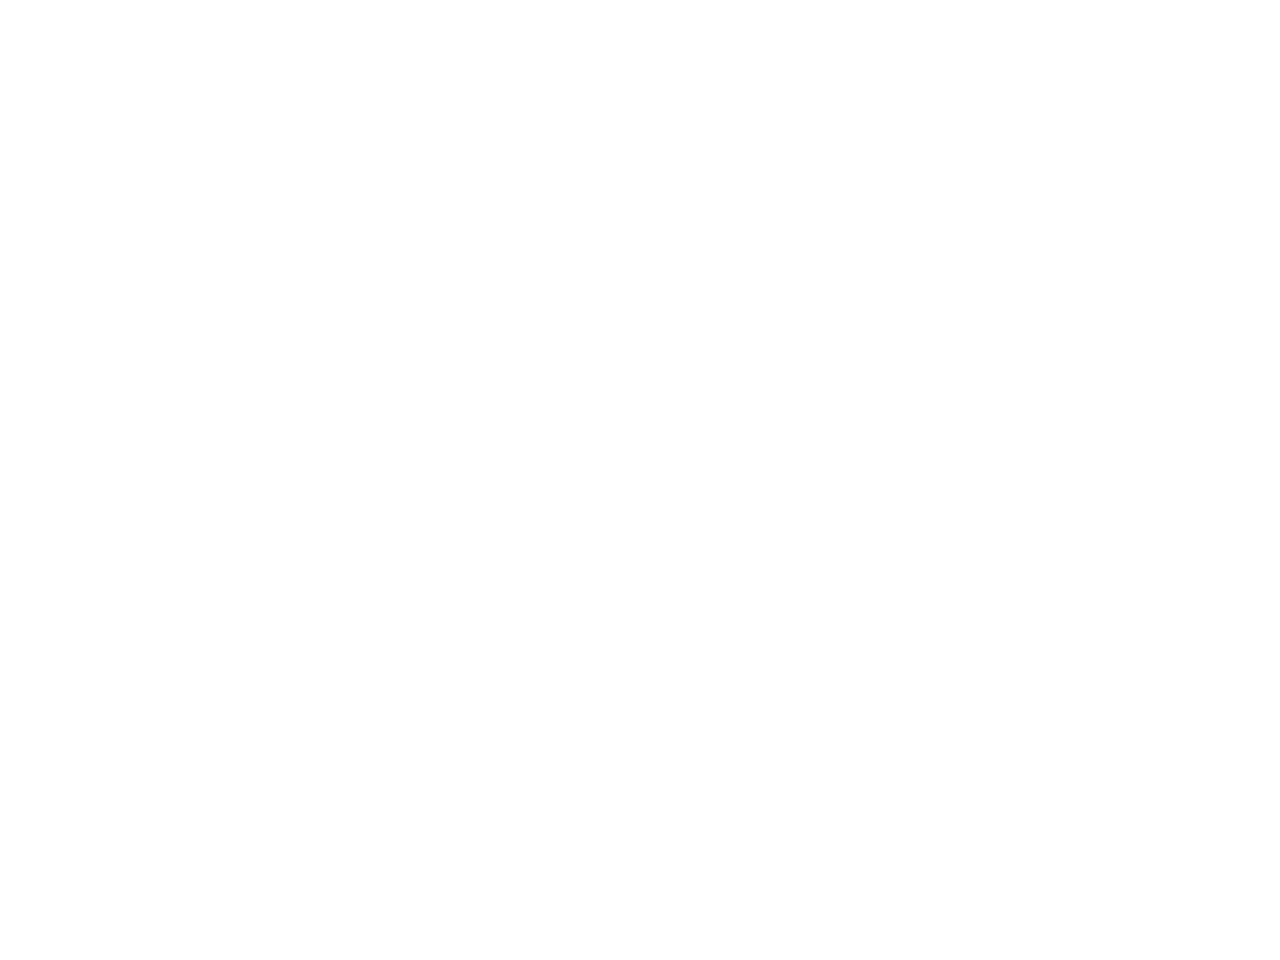

(array([  3.,  29.,  75., 244., 414., 494., 344., 163.,  72.,  16.]),
 array([0.54541995, 0.63811729, 0.73081462, 0.82351195, 0.91620928,
        1.00890662, 1.10160395, 1.19430128, 1.28699862, 1.37969595,
        1.47239328]),
 <BarContainer object of 10 artists>)

In [13]:
### Radius
%matplotlib notebook
import matplotlib.pyplot as plt
concept_radius_in_feat = np.sqrt((coordinates**2).sum(1))

plt.clf()
plt.hist(concept_radius_in_feat)

In [14]:
### Radius vs. memorability
# Euclidean: R^2 = 0.006, adjsuted = 0.005
zscore_mem = stats.zscore(mean_concept_in_feat_cat['cr'])
mean_concept_radius_const = sm.add_constant(concept_radius_in_feat, prepend=False)
mod = sm.OLS(zscore_mem, mean_concept_radius_const)

res = mod.fit()
print(res.summary(xname=['radius','const']))

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     5.858
Date:                Tue, 29 Nov 2022   Prob (F-statistic):             0.0156
Time:                        12:55:29   Log-Likelihood:                -2627.8
No. Observations:                1854   AIC:                             5260.
Df Residuals:                    1852   BIC:                             5271.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
radius        -0.3989      0.165     -2.420      0.0

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [15]:
results['radius_mem'] = [res.rsquared, res.rsquared_adj, np.array(res.params), np.array(res.pvalues), res.aic, res.bic, res.fvalue, res.f_pvalue, res.llf]
results


,cart_coord_mem,radius_mem
rsquared,0.261686,0.003153
rsquared_adj,0.255256,0.002615
coef,"[-0.4113813827081032, 0.5241841332997773, -0.5...","[-0.39894930203445955, 0.4147535519620429]"
pvalues,"[0.00010821903390705268, 8.566830661841044e-07...","[0.015603490510010117, 0.016564522162126283]"
AIC,4732.945846,5259.569171
BIC,4826.872559,5270.619373
F-statistic,40.693868,5.857839
F-stats-prob,0.0,0.015603
Log-Likelihood,-2349.472923,-2627.784586


### KMeans

In [16]:
## import math

inertia = []
for i in range(1, 15):
    kmeans = KMeans(n_clusters=i, random_state=42).fit(coordinates)
#     print(kmeans.inertia_)
    inertia.append(kmeans.inertia_)
print(inertia)

[1439.843407366207, 1228.3003397949096, 1100.735567011124, 1021.8154036040484, 952.6565237750956, 898.8818555410745, 851.031799456746, 811.1132397603868, 781.3760266088817, 755.3190240168095, 737.0261486742014, 722.1931209912401, 705.7475723447509, 692.5833235572871]


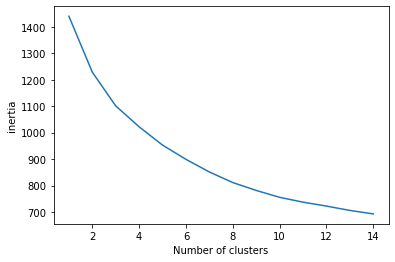

In [17]:
%matplotlib inline
plt.plot(range(1, 15), inertia)
plt.xlabel('Number of clusters')
plt.ylabel('inertia') 
plt.show()
    

In [18]:
### K-Means clustering on concepts
kmeans = KMeans(n_clusters=4, random_state=42).fit(coordinates)
labels = kmeans.labels_
concept_coord_cluster = mean_concept_in_feat_cat
concept_coord_cluster['label'] = labels
kmeans.cluster_centers_


array([[ 0.12487553, -0.31657565,  0.14916807, -0.04359262,  0.06239109,
        -0.20690114, -0.18564158,  0.13449684,  0.03115701, -0.095816  ,
         0.01965043,  0.07304846,  0.10581614, -0.17997816,  0.00927512,
        -0.20480016],
       [ 0.14500109, -0.06676606,  0.34541017,  0.31532647, -0.01355697,
        -0.19464305, -0.22260385, -0.05123018,  0.04467109, -0.34396211,
         0.02970123, -0.06474061,  0.22465153, -0.22028445, -0.07623213,
        -0.00896998],
       [-0.1441585 , -0.00476219, -0.15464942,  0.11422938, -0.03365453,
        -0.10652355,  0.02937137,  0.00749553,  0.3269109 , -0.1512868 ,
         0.27451097,  0.33673392,  0.34619361,  0.08309119,  0.13232691,
         0.12914272],
       [ 0.26800185, -0.35618461,  0.406404  ,  0.09461192, -0.14700701,
        -0.18023133, -0.07926047, -0.22640775,  0.03188673, -0.32530885,
        -0.14627966, -0.07874897,  0.36132211, -0.0714255 ,  0.0742525 ,
        -0.07865866]])

In [19]:
### cluster 0: cartesian coordinates vs. memorability
cluster_0 = concept_coord_cluster[concept_coord_cluster['label'] == 0]
zscore_mem_0 = stats.zscore(cluster_0['cr'])
mean_concept_constant = sm.add_constant(cluster_0.loc[:, 0:15], prepend=False)
mod_0 = sm.OLS(zscore_mem_0, mean_concept_constant)

res_0 = mod_0.fit()
print(res_0.summary())


                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.207
Model:                            OLS   Adj. R-squared:                  0.182
Method:                 Least Squares   F-statistic:                     8.172
Date:                Tue, 29 Nov 2022   Prob (F-statistic):           1.49e-17
Time:                        12:55:31   Log-Likelihood:                -673.54
No. Observations:                 517   AIC:                             1381.
Df Residuals:                     500   BIC:                             1453.
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0             -0.9033      0.284     -3.186      0.0

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [20]:
results['cluster_cart_mem'] = [[res_0.rsquared], [res_0.rsquared_adj], [np.array(res_0.params)], [np.array(res_0.pvalues)], [res_0.aic], [res_0.bic], [res_0.fvalue], [res_0.f_pvalue], [res_0.llf]]
results

,cart_coord_mem,radius_mem,cluster_cart_mem
rsquared,0.261686,0.003153,[0.2072870497185293]
rsquared_adj,0.255256,0.002615,[0.18192023530952217]
coef,"[-0.4113813827081032, 0.5241841332997773, -0.5...","[-0.39894930203445955, 0.4147535519620429]","[[-0.9033264496594419, -0.09681083346061661, -..."
pvalues,"[0.00010821903390705268, 8.566830661841044e-07...","[0.015603490510010117, 0.016564522162126283]","[[0.0015347187044239346, 0.6443990925170426, 0..."
AIC,4732.945846,5259.569171,[1381.0863924206556]
BIC,4826.872559,5270.619373,[1453.3031212872988]
F-statistic,40.693868,5.857839,[8.171583801430238]
F-stats-prob,0.0,0.015603,[1.4942162641685866e-17]
Log-Likelihood,-2349.472923,-2627.784586,[-673.5431962103278]


In [21]:
### cluster 0: radius vs. memorability
radius_cluster_0 = concept_coord_cluster[concept_coord_cluster['label'] == 0]
zscore_mem_0 = stats.zscore(radius_cluster_0['cr'])
mean_concept_constant = sm.add_constant(np.sqrt((radius_cluster_0.loc[:, 0:15]**2).sum(1)), prepend=False)
mod_r_0 = sm.OLS(zscore_mem_0, mean_concept_constant)

res_r_0 = mod_r_0.fit()
print(res_r_0.summary())

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.3802
Date:                Tue, 29 Nov 2022   Prob (F-statistic):              0.538
Time:                        12:55:31   Log-Likelihood:                -733.40
No. Observations:                 517   AIC:                             1471.
Df Residuals:                     515   BIC:                             1479.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0              0.2102      0.341      0.617      0.5

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [22]:
results['cluster_radius_mem'] = [[res_r_0.rsquared], [res_r_0.rsquared_adj], [np.array(res_r_0.params)], [np.array(res_r_0.pvalues)], [res_r_0.aic], [res_r_0.bic], [res_r_0.fvalue], [res_r_0.f_pvalue], [res_r_0.llf]]
results

,cart_coord_mem,radius_mem,cluster_cart_mem,cluster_radius_mem
rsquared,0.261686,0.003153,[0.2072870497185293],[0.0007376729645499625]
rsquared_adj,0.255256,0.002615,[0.18192023530952217],[-0.0012026422335771336]
coef,"[-0.4113813827081032, 0.5241841332997773, -0.5...","[-0.39894930203445955, 0.4147535519620429]","[[-0.9033264496594419, -0.09681083346061661, -...","[[0.2102182483830038, -0.20669837411993386]]"
pvalues,"[0.00010821903390705268, 8.566830661841044e-07...","[0.015603490510010117, 0.016564522162126283]","[[0.0015347187044239346, 0.6443990925170426, 0...","[[0.5377782949690498, 0.541248237675543]]"
AIC,4732.945846,5259.569171,[1381.0863924206556],[1470.8009256760215]
BIC,4826.872559,5270.619373,[1453.3031212872988],[1479.2970114250384]
F-statistic,40.693868,5.857839,[8.171583801430238],[0.3801820267459409]
F-stats-prob,0.0,0.015603,[1.4942162641685866e-17],[0.537778294969061]
Log-Likelihood,-2349.472923,-2627.784586,[-673.5431962103278],[-733.4004628380108]


In [23]:
### cluster 1: cartesian coordinates vs. memorability
cluster_1 = concept_coord_cluster[concept_coord_cluster['label'] == 1]
zscore_mem_1 = stats.zscore(cluster_1['cr'])
mean_concept_constant = sm.add_constant(cluster_1.loc[:, 0:15], prepend=False)
mod_1 = sm.OLS(zscore_mem_1, mean_concept_constant)

res_1 = mod_1.fit()
print(res_1.summary())

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.287
Model:                            OLS   Adj. R-squared:                  0.267
Method:                 Least Squares   F-statistic:                     14.69
Date:                Tue, 29 Nov 2022   Prob (F-statistic):           8.20e-34
Time:                        12:55:31   Log-Likelihood:                -752.51
No. Observations:                 602   AIC:                             1539.
Df Residuals:                     585   BIC:                             1614.
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0             -0.0805      0.302     -0.266      0.7

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [24]:
row = 0
for stat in [res_1.rsquared, res_1.rsquared_adj, np.array(res_1.params), np.array(res_1.pvalues), res_1.aic, res_1.bic, res_1.fvalue, res_1.f_pvalue, res_1.llf]:
    results.iloc[row]['cluster_cart_mem'].append(stat)
    row += 1

In [25]:
### cluster 1: radius vs. memorability
radius_cluster_1 = concept_coord_cluster[concept_coord_cluster['label'] == 1]
zscore_mem_1 = stats.zscore(radius_cluster_1['cr'])
mean_concept_constant = sm.add_constant(np.sqrt((radius_cluster_1.loc[:, 0:15]**2).sum(1)), prepend=False)
mod_r_1 = sm.OLS(zscore_mem_1, mean_concept_constant)

res_r_1 = mod_r_1.fit()
print(res_r_1.summary())

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.079
Model:                            OLS   Adj. R-squared:                  0.077
Method:                 Least Squares   F-statistic:                     51.20
Date:                Tue, 29 Nov 2022   Prob (F-statistic):           2.44e-12
Time:                        12:55:31   Log-Likelihood:                -829.55
No. Observations:                 602   AIC:                             1663.
Df Residuals:                     600   BIC:                             1672.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0             -2.3893      0.334     -7.156      0.0

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [26]:
row = 0
for stat in [res_r_1.rsquared, res_r_1.rsquared_adj, np.array(res_r_1.params), np.array(res_r_1.pvalues), res_r_1.aic, res_r_1.bic, res_r_1.fvalue, res_r_1.f_pvalue, res_r_1.llf]:
    results.iloc[row]['cluster_radius_mem'].append(stat)
    row += 1

In [27]:
### cluster 2: cartesian coordinates vs. memorability
cluster_2 = concept_coord_cluster[concept_coord_cluster['label'] == 2]
zscore_mem_2 = stats.zscore(cluster_2['cr'])
mean_concept_constant = sm.add_constant(cluster_2.loc[:, 0:15], prepend=False)
mod_2 = sm.OLS(zscore_mem_2, mean_concept_constant)

res_2 = mod_2.fit()
print(res_2.summary())

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.315
Model:                            OLS   Adj. R-squared:                  0.273
Method:                 Least Squares   F-statistic:                     7.574
Date:                Tue, 29 Nov 2022   Prob (F-statistic):           1.29e-14
Time:                        12:55:31   Log-Likelihood:                -345.64
No. Observations:                 281   AIC:                             725.3
Df Residuals:                     264   BIC:                             787.1
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0             -1.0825      0.352     -3.076      0.0

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [28]:
row = 0
for stat in [res_2.rsquared, res_2.rsquared_adj, np.array(res_2.params), np.array(res_2.pvalues), res_2.aic, res_2.bic, res_2.fvalue, res_2.f_pvalue, res_2.llf]:
    results.iloc[row]['cluster_cart_mem'].append(stat)
    row += 1

In [29]:
### cluster 2: radius vs. memorability
radius_cluster_2 = concept_coord_cluster[concept_coord_cluster['label'] == 2]
zscore_mem_2 = stats.zscore(radius_cluster_2['cr'])
mean_concept_constant = sm.add_constant(np.sqrt((radius_cluster_2.loc[:, 0:15]**2).sum(1)), prepend=False)
mod_r_2 = sm.OLS(zscore_mem_2, mean_concept_constant)

res_r_2 = mod_r_2.fit()
print(res_r_2.summary())

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.110
Model:                            OLS   Adj. R-squared:                  0.106
Method:                 Least Squares   F-statistic:                     34.33
Date:                Tue, 29 Nov 2022   Prob (F-statistic):           1.31e-08
Time:                        12:55:31   Log-Likelihood:                -382.42
No. Observations:                 281   AIC:                             768.8
Df Residuals:                     279   BIC:                             776.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0              2.4413      0.417      5.859      0.0

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [30]:
row = 0
for stat in [res_r_2.rsquared, res_r_2.rsquared_adj, np.array(res_r_2.params), np.array(res_r_2.pvalues), res_r_2.aic, res_r_2.bic, res_r_2.fvalue, res_r_2.f_pvalue, res_r_2.llf]:
    results.iloc[row]['cluster_radius_mem'].append(stat)
    row += 1

In [31]:
### cluster 3: cartesian coordinates vs. memorability
cluster_3 = concept_coord_cluster[concept_coord_cluster['label'] == 3]
zscore_mem_3 = stats.zscore(cluster_3['cr'])
mean_concept_constant = sm.add_constant(cluster_3.loc[:, 0:15], prepend=False)
mod_3 = sm.OLS(zscore_mem_3, mean_concept_constant)

res_3 = mod_3.fit()
print(res_3.summary())

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.211
Model:                            OLS   Adj. R-squared:                  0.183
Method:                 Least Squares   F-statistic:                     7.322
Date:                Tue, 29 Nov 2022   Prob (F-statistic):           3.32e-15
Time:                        12:55:31   Log-Likelihood:                -590.29
No. Observations:                 454   AIC:                             1215.
Df Residuals:                     437   BIC:                             1285.
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0             -0.3915      0.269     -1.457      0.1

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [32]:
row = 0
for stat in [res_3.rsquared, res_3.rsquared_adj, np.array(res_3.params), np.array(res_3.pvalues), res_3.aic, res_3.bic, res_3.fvalue, res_3.f_pvalue, res_3.llf]:
    results.iloc[row]['cluster_cart_mem'].append(stat)
    row += 1

In [33]:
### cluster 3: radius vs. memorability
radius_cluster_3 = concept_coord_cluster[concept_coord_cluster['label'] == 3]
zscore_mem_3 = stats.zscore(radius_cluster_3['cr'])
mean_concept_constant = sm.add_constant(np.sqrt((radius_cluster_3.loc[:, 0:15]**2).sum(1)), prepend=False)
mod_r_3 = sm.OLS(zscore_mem_3, mean_concept_constant)

res_r_3 = mod_r_3.fit()
print(res_r_3.summary())

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.194
Date:                Tue, 29 Nov 2022   Prob (F-statistic):              0.275
Time:                        12:55:31   Log-Likelihood:                -643.60
No. Observations:                 454   AIC:                             1291.
Df Residuals:                     452   BIC:                             1299.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0              0.3702      0.339      1.093      0.2

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [34]:
row = 0
for stat in [res_r_3.rsquared, res_r_3.rsquared_adj, np.array(res_r_3.params), np.array(res_r_3.pvalues), res_r_3.aic, res_r_3.bic, res_r_3.fvalue, res_r_3.f_pvalue, res_r_3.llf]:
    results.iloc[row]['cluster_radius_mem'].append(stat)
    row += 1

In [35]:
r_squared = 1 - (sum((zscore_mem_0 - res_0.fittedvalues)**2) + sum((zscore_mem_1 - res_1.fittedvalues)**2) + sum((zscore_mem_2 - res_2.fittedvalues)**2) + sum((zscore_mem_3 - res_3.fittedvalues)**2)) / (sum((zscore_mem_0 - zscore_mem_0.mean())**2) + sum((zscore_mem_1 - zscore_mem_1.mean())**2) + sum((zscore_mem_2 - zscore_mem_2.mean())**2) + sum((zscore_mem_3 - zscore_mem_3.mean())**2))
results.iloc[0]['cluster_cart_mem'].append(r_squared)
r_squared

0.25034506252355404

In [36]:
r_squared = 1 - (sum((zscore_mem_0 - res_r_0.fittedvalues)**2) + sum((zscore_mem_1 - res_r_1.fittedvalues)**2) + sum((zscore_mem_2 - res_r_2.fittedvalues)**2) + sum((zscore_mem_3 - res_r_3.fittedvalues)**2)) / (sum((zscore_mem_0 - zscore_mem_0.mean())**2) + sum((zscore_mem_1 - zscore_mem_1.mean())**2) + sum((zscore_mem_2 - zscore_mem_2.mean())**2) + sum((zscore_mem_3 - zscore_mem_3.mean())**2))
results.iloc[0]['cluster_radius_mem'].append(r_squared)
r_squared

0.04298710123893468

### Typicality

In [37]:
def calculate_typicality(group):
    """
    Calculate typicality of each concept using average similarity within category 
    """
    feat_matrix = []
    for concept in group['index']:
        feat_matrix.append(original_embeddings[concept])
    coef_matrix = np.corrcoef(feat_matrix)
    typicality = (np.sum(coef_matrix, axis=1)-1)/len(coef_matrix)
    group['typicality'] = typicality
    return group

In [38]:
grouped = mean_concept_in_feat_cat_na.groupby('bigcat')
grouped = grouped.apply(calculate_typicality)
grouped

,index,0,1,2,3,4,5,6,7,8,...,10,11,12,13,14,15,cr,bigcat,cat_name,typicality
0,0,0.246225,-0.613591,0.275662,-0.176593,0.058854,-0.297085,-0.199909,0.122661,-0.074639,...,0.060460,0.332694,0.048010,-0.216537,0.193114,-0.326042,0.779739,1,animal,0.810913
1,1,0.253400,-0.079725,0.385615,0.012182,-0.383324,-0.075660,-0.379949,-0.073255,0.023986,...,-0.036276,-0.192243,0.217377,-0.321806,-0.093524,-0.322752,0.798485,13,home decor,0.247628
2,2,0.303775,-0.273326,0.261047,0.212491,-0.343556,-0.013515,-0.110962,-0.064640,-0.305945,...,-0.119424,-0.305162,0.452085,-0.451478,0.244116,-0.016692,0.752845,18,musical instrument,0.624589
4,4,0.124995,-0.354985,0.078723,0.012196,0.249719,-0.160851,-0.464347,-0.520639,0.094928,...,-0.079225,-0.080322,0.144100,-0.324339,0.251654,0.008187,0.794466,9,electronic device,0.522380
5,5,-0.050371,-0.164876,0.036221,0.157799,0.203595,-0.292897,-0.300855,-0.163993,-0.020737,...,0.206306,0.002999,0.116559,-0.104572,0.194971,0.021422,0.806000,12,furniture,0.509185
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1847,1847,0.446488,0.276068,0.195881,-0.322367,-0.206753,0.049438,-0.070681,0.494646,-0.004339,...,-0.165659,0.289559,0.017386,0.343176,-0.055820,0.293999,0.803129,24,toy,0.246697
1848,1848,0.313951,-0.027569,0.315936,0.347866,0.091833,-0.080746,0.016872,-0.065939,0.093715,...,0.254015,-0.037855,0.435853,-0.127405,-0.168798,0.001261,0.765881,10,food,0.786900
1850,1850,0.340153,0.067813,0.434438,0.225263,0.146513,-0.073237,-0.265157,-0.003018,0.136013,...,0.104562,-0.064829,0.354778,-0.073047,-0.076729,0.013500,0.843158,10,food,0.770485
1851,1851,0.144987,-0.586506,0.176726,-0.206531,0.033350,-0.255985,-0.225570,0.109486,-0.143501,...,0.153218,0.178766,-0.165467,-0.288792,0.246337,-0.340726,0.800163,1,animal,0.764335


In [39]:
### Cartesian coordinates vs. typicality
# Euclidean: R^2 = 0.492, adjusted = 0.485
# normalized: R^2 = 0.479, adjusted = 0.478
# mobius: R^2 = 0.136, adjusted = 0.134

zscore_mem = stats.zscore(grouped['typicality'])
mean_concept_constant = sm.add_constant(grouped.loc[:, 0:15], prepend=False)
mod = sm.OLS(zscore_mem, mean_concept_constant)

res = mod.fit()
print(res.summary())
results['cart_typ'] = [res.rsquared, res.rsquared_adj, np.array(res.params), np.array(res.pvalues), res.aic, res.bic, res.fvalue, res.f_pvalue, res.llf]

                            OLS Regression Results                            
Dep. Variable:             typicality   R-squared:                       0.354
Model:                            OLS   Adj. R-squared:                  0.346
Method:                 Least Squares   F-statistic:                     44.80
Date:                Tue, 29 Nov 2022   Prob (F-statistic):          6.07e-112
Time:                        12:55:31   Log-Likelihood:                -1589.2
No. Observations:                1324   AIC:                             3212.
Df Residuals:                    1307   BIC:                             3301.
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0              0.4006      0.118      3.399      0.0

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [40]:
### Radius vs. typicality
# Euclidean: R^2 = 0.023, adjusted = 0.023
# normalized: R^2 = 0.388, adjusted = 0.388

concept_radius_typ = np.sqrt((grouped.loc[:, 0:15]**2).sum(1))
zscore_mem = stats.zscore(grouped['typicality'])
mean_concept_constant = sm.add_constant(concept_radius_typ, prepend=False)
mod = sm.OLS(zscore_mem, mean_concept_constant)

res = mod.fit()
print(res.summary(xname=['radius', 'const']))
results['radius_typ'] = [res.rsquared, res.rsquared_adj, np.array(res.params), np.array(res.pvalues), res.aic, res.bic, res.fvalue, res.f_pvalue, res.llf]

                            OLS Regression Results                            
Dep. Variable:             typicality   R-squared:                       0.009
Model:                            OLS   Adj. R-squared:                  0.009
Method:                 Least Squares   F-statistic:                     12.45
Date:                Tue, 29 Nov 2022   Prob (F-statistic):           0.000432
Time:                        12:55:31   Log-Likelihood:                -1872.5
No. Observations:                1324   AIC:                             3749.
Df Residuals:                    1322   BIC:                             3759.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
radius         0.6926      0.196      3.529      0.0

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [41]:
### Cartesian coordinates and typicality vs. memorability
# Euclidean: R^2 = 0.301, adjusted = 0.292
# normalized: R^2 = 0.107, adjusted = 0.104

zscore_mem = stats.zscore(grouped['cr'])
idx = [i for i in range(0, 16)]
idx.append('typicality')
mean_concept_constant = sm.add_constant(np.array(grouped[idx]), prepend=False)
mod = sm.OLS(zscore_mem, mean_concept_constant)

res = mod.fit()
print(res.summary())
results['cart_typ_mem'] = [res.rsquared, res.rsquared_adj, np.array(res.params), np.array(res.pvalues), res.aic, res.bic, res.fvalue, res.f_pvalue, res.llf]

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.298
Model:                            OLS   Adj. R-squared:                  0.289
Method:                 Least Squares   F-statistic:                     32.68
Date:                Tue, 29 Nov 2022   Prob (F-statistic):           3.50e-88
Time:                        12:55:31   Log-Likelihood:                -1644.0
No. Observations:                1324   AIC:                             3324.
Df Residuals:                    1306   BIC:                             3417.
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.3100      0.123     -2.511      0.0

In [42]:
### Radius and typicality vs. memorability
# Euclidean: R^2 = 0.041, adjusted = 0.040
# normalized: R^2 = 0.046, adjusted = 0.044

zscore_mem = stats.zscore(grouped['cr'])
mean_concept_constant = sm.add_constant(np.array([concept_radius_typ, grouped['typicality']]).T, prepend=False)
mod = sm.OLS(zscore_mem, mean_concept_constant)

res = mod.fit()
print(res.summary(xname=['radius','typicality', 'const']))
results['radius_typ_mem'] = [res.rsquared, res.rsquared_adj, np.array(res.params), np.array(res.pvalues), res.aic, res.bic, res.fvalue, res.f_pvalue, res.llf]

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.036
Model:                            OLS   Adj. R-squared:                  0.034
Method:                 Least Squares   F-statistic:                     24.52
Date:                Tue, 29 Nov 2022   Prob (F-statistic):           3.51e-11
Time:                        12:55:31   Log-Likelihood:                -1854.5
No. Observations:                1324   AIC:                             3715.
Df Residuals:                    1321   BIC:                             3731.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
radius        -0.4429      0.195     -2.276      0.0

In [91]:
zscore_mem = stats.zscore(grouped['cr'])
mean_concept_constant = sm.add_constant(grouped['typicality'], prepend=False)
mod = sm.OLS(zscore_mem, mean_concept_constant)

res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.032
Model:                            OLS   Adj. R-squared:                  0.031
Method:                 Least Squares   F-statistic:                     43.72
Date:                Tue, 29 Nov 2022   Prob (F-statistic):           5.50e-11
Time:                        12:57:40   Log-Likelihood:                -1857.1
No. Observations:                1324   AIC:                             3718.
Df Residuals:                    1322   BIC:                             3729.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
typicality     0.9536      0.144      6.612      0.0

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


##### Cluster level typicality

In [43]:
typ_coord_cluster = concept_coord_cluster.merge(grouped[['index','typicality']], how='inner', on='index')
typ_coord_cluster

,index,0,1,2,3,4,5,6,7,8,...,11,12,13,14,15,cr,bigcat,cat_name,label,typicality
0,0,0.246225,-0.613591,0.275662,-0.176593,0.058854,-0.297085,-0.199909,0.122661,-0.074639,...,0.332694,0.048010,-0.216537,0.193114,-0.326042,0.779739,1,animal,0,0.810913
1,1,0.253400,-0.079725,0.385615,0.012182,-0.383324,-0.075660,-0.379949,-0.073255,0.023986,...,-0.192243,0.217377,-0.321806,-0.093524,-0.322752,0.798485,13,home decor,1,0.247628
2,2,0.303775,-0.273326,0.261047,0.212491,-0.343556,-0.013515,-0.110962,-0.064640,-0.305945,...,-0.305162,0.452085,-0.451478,0.244116,-0.016692,0.752845,18,musical instrument,3,0.624589
3,4,0.124995,-0.354985,0.078723,0.012196,0.249719,-0.160851,-0.464347,-0.520639,0.094928,...,-0.080322,0.144100,-0.324339,0.251654,0.008187,0.794466,9,electronic device,0,0.522380
4,5,-0.050371,-0.164876,0.036221,0.157799,0.203595,-0.292897,-0.300855,-0.163993,-0.020737,...,0.002999,0.116559,-0.104572,0.194971,0.021422,0.806000,12,furniture,0,0.509185
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1319,1847,0.446488,0.276068,0.195881,-0.322367,-0.206753,0.049438,-0.070681,0.494646,-0.004339,...,0.289559,0.017386,0.343176,-0.055820,0.293999,0.803129,24,toy,0,0.246697
1320,1848,0.313951,-0.027569,0.315936,0.347866,0.091833,-0.080746,0.016872,-0.065939,0.093715,...,-0.037855,0.435853,-0.127405,-0.168798,0.001261,0.765881,10,food,1,0.786900
1321,1850,0.340153,0.067813,0.434438,0.225263,0.146513,-0.073237,-0.265157,-0.003018,0.136013,...,-0.064829,0.354778,-0.073047,-0.076729,0.013500,0.843158,10,food,1,0.770485
1322,1851,0.144987,-0.586506,0.176726,-0.206531,0.033350,-0.255985,-0.225570,0.109486,-0.143501,...,0.178766,-0.165467,-0.288792,0.246337,-0.340726,0.800163,1,animal,0,0.764335


In [44]:
### cluster 0: cartesian coordinates + typicality vs. memorability
cluster_0 = typ_coord_cluster[typ_coord_cluster['label'] == 0]
zscore_mem_0 = stats.zscore(cluster_0['cr'])
mean_concept_constant = sm.add_constant(cluster_0[idx], prepend=False)
mod_0 = sm.OLS(zscore_mem_0, mean_concept_constant)

res_0 = mod_0.fit()
print(res_0.summary())
results['cluster_cart_typ_mem'] = [[res_0.rsquared], [res_0.rsquared_adj], [np.array(res_0.params)], [np.array(res_0.pvalues)], [res_0.aic], [res_0.bic], [res_0.fvalue], [res_0.f_pvalue], [res_0.llf]]


                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.326
Model:                            OLS   Adj. R-squared:                  0.292
Method:                 Least Squares   F-statistic:                     9.496
Date:                Tue, 29 Nov 2022   Prob (F-statistic):           2.57e-20
Time:                        12:55:31   Log-Likelihood:                -428.68
No. Observations:                 351   AIC:                             893.4
Df Residuals:                     333   BIC:                             962.9
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0             -1.0320      0.352     -2.931      0.0

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [45]:
cluster_0 = typ_coord_cluster[typ_coord_cluster['label'] == 0]
zscore_mem_0 = stats.zscore(cluster_0['typicality'])
mean_concept_constant = sm.add_constant(cluster_0.loc[:, 0:15], prepend=False)
mod_0_typ = sm.OLS(zscore_mem_0, mean_concept_constant)

res_0_typ = mod_0_typ.fit()
print(res_0_typ.summary())

                            OLS Regression Results                            
Dep. Variable:             typicality   R-squared:                       0.713
Model:                            OLS   Adj. R-squared:                  0.699
Method:                 Least Squares   F-statistic:                     51.75
Date:                Tue, 29 Nov 2022   Prob (F-statistic):           3.05e-80
Time:                        12:55:32   Log-Likelihood:                -279.25
No. Observations:                 351   AIC:                             592.5
Df Residuals:                     334   BIC:                             658.1
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0              0.1694      0.229      0.738      0.4

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [46]:
### cluster 0: radius + typicality vs. memorability
polar_cluster_0 = typ_coord_cluster[typ_coord_cluster['label'] == 0]
radius_cluster_0 = pd.concat([np.sqrt((polar_cluster_0.loc[:, 0:15]**2).sum(1)), polar_cluster_0['typicality']], axis=1)
zscore_mem_0 = stats.zscore(polar_cluster_0['cr'])
mean_concept_constant = sm.add_constant(radius_cluster_0[[0, 'typicality']], prepend=False)
mod_r_0 = sm.OLS(zscore_mem_0, mean_concept_constant)

res_r_0 = mod_r_0.fit()
print(res_r_0.summary())
results['cluster_radius_typ_mem'] = [[res_r_0.rsquared], [res_r_0.rsquared_adj], [np.array(res_r_0.params)], [np.array(res_r_0.pvalues)], [res_r_0.aic], [res_r_0.bic], [res_r_0.fvalue], [res_r_0.f_pvalue], [res_r_0.llf]]


                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.065
Model:                            OLS   Adj. R-squared:                  0.059
Method:                 Least Squares   F-statistic:                     12.06
Date:                Tue, 29 Nov 2022   Prob (F-statistic):           8.66e-06
Time:                        12:55:32   Log-Likelihood:                -486.29
No. Observations:                 351   AIC:                             978.6
Df Residuals:                     348   BIC:                             990.2
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0             -0.5092      0.420     -1.212      0.2

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [47]:
### cluster 1: cartesian coordinates + typicality vs. memorability
cluster_1 = typ_coord_cluster[typ_coord_cluster['label'] == 1]
zscore_mem_1 = stats.zscore(cluster_1['cr'])
mean_concept_constant = sm.add_constant(cluster_1[idx], prepend=False)
mod_1 = sm.OLS(zscore_mem_1, mean_concept_constant)

res_1 = mod_1.fit()
print(res_1.summary())

row = 0
for stat in [res_1.rsquared, res_1.rsquared_adj, np.array(res_1.params), np.array(res_1.pvalues), res_1.aic, res_1.bic, res_1.fvalue, res_1.f_pvalue, res_1.llf]:
    results.iloc[row]['cluster_cart_typ_mem'].append(stat)
    row += 1

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.291
Model:                            OLS   Adj. R-squared:                  0.264
Method:                 Least Squares   F-statistic:                     10.72
Date:                Tue, 29 Nov 2022   Prob (F-statistic):           2.30e-24
Time:                        12:55:32   Log-Likelihood:                -576.09
No. Observations:                 462   AIC:                             1188.
Df Residuals:                     444   BIC:                             1263.
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0              0.0298      0.374      0.080      0.9

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [48]:
cluster_1 = typ_coord_cluster[typ_coord_cluster['label'] == 1]
zscore_mem_1 = stats.zscore(cluster_1['typicality'])
mean_concept_constant = sm.add_constant(cluster_1.loc[:, 0:15], prepend=False)
mod_1_typ = sm.OLS(zscore_mem_1, mean_concept_constant)

res_1_typ = mod_1_typ.fit()
print(res_1_typ.summary())

                            OLS Regression Results                            
Dep. Variable:             typicality   R-squared:                       0.597
Model:                            OLS   Adj. R-squared:                  0.582
Method:                 Least Squares   F-statistic:                     41.17
Date:                Tue, 29 Nov 2022   Prob (F-statistic):           2.80e-77
Time:                        12:55:32   Log-Likelihood:                -445.72
No. Observations:                 462   AIC:                             925.4
Df Residuals:                     445   BIC:                             995.7
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0             -0.7606      0.279     -2.726      0.0

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [49]:
### cluster 1: radius + typicality vs. memorability
polar_cluster_1 = typ_coord_cluster[typ_coord_cluster['label'] == 1]
radius_cluster_1 = pd.concat([np.sqrt((polar_cluster_1.loc[:, 0:15]**2).sum(1)), polar_cluster_1['typicality']], axis=1)
zscore_mem_1 = stats.zscore(polar_cluster_1['cr'])
mean_concept_constant = sm.add_constant(radius_cluster_1[[0, 'typicality']], prepend=False)
mod_r_1 = sm.OLS(zscore_mem_1, mean_concept_constant)

res_r_1 = mod_r_1.fit()
print(res_r_1.summary())

row = 0
for stat in [res_r_1.rsquared, res_r_1.rsquared_adj, np.array(res_r_1.params), np.array(res_r_1.pvalues), res_r_1.aic, res_r_1.bic, res_r_1.fvalue, res_r_1.f_pvalue, res_r_1.llf]:
    results.iloc[row]['cluster_radius_typ_mem'].append(stat)
    row += 1

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.111
Model:                            OLS   Adj. R-squared:                  0.107
Method:                 Least Squares   F-statistic:                     28.53
Date:                Tue, 29 Nov 2022   Prob (F-statistic):           2.09e-12
Time:                        12:55:32   Log-Likelihood:                -628.48
No. Observations:                 462   AIC:                             1263.
Df Residuals:                     459   BIC:                             1275.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0             -1.9127      0.399     -4.797      0.0

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [50]:
### cluster 2: cartesian coordinates + typicality vs. memorability
cluster_2 = typ_coord_cluster[typ_coord_cluster['label'] == 2]
zscore_mem_2 = stats.zscore(cluster_2['cr'])
mean_concept_constant = sm.add_constant(cluster_2[idx], prepend=False)
mod_2 = sm.OLS(zscore_mem_2, mean_concept_constant)

res_2 = mod_2.fit()
print(res_2.summary())

row = 0
for stat in [res_2.rsquared, res_2.rsquared_adj, np.array(res_2.params), np.array(res_2.pvalues), res_2.aic, res_2.bic, res_2.fvalue, res_2.f_pvalue, res_2.llf]:
    results.iloc[row]['cluster_cart_typ_mem'].append(stat)
    row += 1

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.307
Model:                            OLS   Adj. R-squared:                  0.243
Method:                 Least Squares   F-statistic:                     4.813
Date:                Tue, 29 Nov 2022   Prob (F-statistic):           1.85e-08
Time:                        12:55:32   Log-Likelihood:                -250.87
No. Observations:                 203   AIC:                             537.7
Df Residuals:                     185   BIC:                             597.4
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0             -0.8373      0.434     -1.931      0.0

In [51]:
cluster_2 = typ_coord_cluster[typ_coord_cluster['label'] == 2]
zscore_mem_2 = stats.zscore(cluster_2['typicality'])
mean_concept_constant = sm.add_constant(cluster_2.loc[:, 0:15], prepend=False)
mod_2_typ = sm.OLS(zscore_mem_2, mean_concept_constant)

res_2_typ = mod_2_typ.fit()
print(res_2_typ.summary())

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


                            OLS Regression Results                            
Dep. Variable:             typicality   R-squared:                       0.579
Model:                            OLS   Adj. R-squared:                  0.543
Method:                 Least Squares   F-statistic:                     15.99
Date:                Tue, 29 Nov 2022   Prob (F-statistic):           4.26e-27
Time:                        12:55:32   Log-Likelihood:                -200.24
No. Observations:                 203   AIC:                             434.5
Df Residuals:                     186   BIC:                             490.8
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0             -0.7139      0.333     -2.145      0.0

In [52]:
### cluster 2: radius + typicality vs. memorability
polar_cluster_2 = typ_coord_cluster[typ_coord_cluster['label'] == 2]
radius_cluster_2 = pd.concat([np.sqrt((polar_cluster_2.loc[:, 0:15]**2).sum(1)), polar_cluster_2['typicality']], axis=1)
zscore_mem_2 = stats.zscore(polar_cluster_2['cr'])
mean_concept_constant = sm.add_constant(radius_cluster_2[[0, 'typicality']], prepend=False)
mod_r_2 = sm.OLS(zscore_mem_2, mean_concept_constant)

res_r_2 = mod_r_2.fit()
print(res_r_2.summary())

row = 0
for stat in [res_r_2.rsquared, res_r_2.rsquared_adj, np.array(res_r_2.params), np.array(res_r_2.pvalues), res_r_2.aic, res_r_2.bic, res_r_2.fvalue, res_r_2.f_pvalue, res_r_2.llf]:
    results.iloc[row]['cluster_radius_typ_mem'].append(stat)
    row += 1

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.125
Model:                            OLS   Adj. R-squared:                  0.117
Method:                 Least Squares   F-statistic:                     14.32
Date:                Tue, 29 Nov 2022   Prob (F-statistic):           1.54e-06
Time:                        12:55:32   Log-Likelihood:                -274.46
No. Observations:                 203   AIC:                             554.9
Df Residuals:                     200   BIC:                             564.9
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0              1.7755      0.583      3.046      0.0

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [53]:
### cluster 3: cartesian coordinates + typicality vs. memorability
cluster_3 = typ_coord_cluster[typ_coord_cluster['label'] == 3]
zscore_mem_3 = stats.zscore(cluster_3['cr'])
mean_concept_constant = sm.add_constant(cluster_3[idx], prepend=False)
mod_3 = sm.OLS(zscore_mem_3, mean_concept_constant)

res_3 = mod_3.fit()
print(res_3.summary())

row = 0
for stat in [res_3.rsquared, res_3.rsquared_adj, np.array(res_3.params), np.array(res_3.pvalues), res_3.aic, res_3.bic, res_3.fvalue, res_3.f_pvalue, res_3.llf]:
    results.iloc[row]['cluster_cart_typ_mem'].append(stat)
    row += 1

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.209
Model:                            OLS   Adj. R-squared:                  0.163
Method:                 Least Squares   F-statistic:                     4.516
Date:                Tue, 29 Nov 2022   Prob (F-statistic):           2.32e-08
Time:                        12:55:32   Log-Likelihood:                -400.87
No. Observations:                 308   AIC:                             837.7
Df Residuals:                     290   BIC:                             904.9
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0             -0.4962      0.348     -1.424      0.1

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [54]:
cluster_3 = typ_coord_cluster[typ_coord_cluster['label'] == 3]
zscore_mem_3 = stats.zscore(cluster_3['typicality'])
mean_concept_constant = sm.add_constant(cluster_3.loc[:, 0:15], prepend=False)
mod_3_typ = sm.OLS(zscore_mem_3, mean_concept_constant)

res_3_typ = mod_3_typ.fit()
print(res_3_typ.summary())

                            OLS Regression Results                            
Dep. Variable:             typicality   R-squared:                       0.482
Model:                            OLS   Adj. R-squared:                  0.453
Method:                 Least Squares   F-statistic:                     16.90
Date:                Tue, 29 Nov 2022   Prob (F-statistic):           6.34e-33
Time:                        12:55:32   Log-Likelihood:                -335.85
No. Observations:                 308   AIC:                             705.7
Df Residuals:                     291   BIC:                             769.1
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0              1.3435      0.270      4.969      0.0

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [55]:
### cluster 3: radius + typicality vs. memorability
polar_cluster_3 = typ_coord_cluster[typ_coord_cluster['label'] == 3]
radius_cluster_3 = pd.concat([np.sqrt((polar_cluster_3.loc[:, 0:15]**2).sum(1)), polar_cluster_3['typicality']], axis=1)
zscore_mem_3 = stats.zscore(polar_cluster_3['cr'])
mean_concept_constant = sm.add_constant(radius_cluster_3[[0, 'typicality']], prepend=False)
mod_r_3 = sm.OLS(zscore_mem_3, mean_concept_constant)

res_r_3 = mod_r_3.fit()
print(res_r_3.summary())

row = 0
for stat in [res_r_3.rsquared, res_r_3.rsquared_adj, np.array(res_r_3.params), np.array(res_r_3.pvalues), res_r_3.aic, res_r_3.bic, res_r_3.fvalue, res_r_3.f_pvalue, res_r_3.llf]:
    results.iloc[row]['cluster_radius_typ_mem'].append(stat)
    row += 1

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.012
Model:                            OLS   Adj. R-squared:                  0.006
Method:                 Least Squares   F-statistic:                     1.877
Date:                Tue, 29 Nov 2022   Prob (F-statistic):              0.155
Time:                        12:55:32   Log-Likelihood:                -435.15
No. Observations:                 308   AIC:                             876.3
Df Residuals:                     305   BIC:                             887.5
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0              0.8725      0.450      1.937      0.0

Taking typicality into account, on cluster level, coordinates and typicality of concepts in euclidean space explained more variance in memorability compared to coordinates only. 

In [56]:
r_squared = 1 - (sum((zscore_mem_0 - res_0.fittedvalues)**2) + sum((zscore_mem_1 - res_1.fittedvalues)**2) + sum((zscore_mem_2 - res_2.fittedvalues)**2) + sum((zscore_mem_3 - res_3.fittedvalues)**2)) / (sum((zscore_mem_0 - zscore_mem_0.mean())**2) + sum((zscore_mem_1 - zscore_mem_1.mean())**2) + sum((zscore_mem_2 - zscore_mem_2.mean())**2) + sum((zscore_mem_3 - zscore_mem_3.mean())**2))
results.iloc[0]['cluster_cart_typ_mem'].append(r_squared)
r_squared

0.2838282347727392

In [57]:
r_squared = 1 - (sum((zscore_mem_0 - res_0_typ.fittedvalues)**2) + sum((zscore_mem_1 - res_1_typ.fittedvalues)**2) + sum((zscore_mem_2 - res_2_typ.fittedvalues)**2) + sum((zscore_mem_3 - res_3_typ.fittedvalues)**2)) / (sum((zscore_mem_0 - zscore_mem_0.mean())**2) + sum((zscore_mem_1 - zscore_mem_1.mean())**2) + sum((zscore_mem_2 - zscore_mem_2.mean())**2) + sum((zscore_mem_3 - zscore_mem_3.mean())**2))
results.iloc[0]['cluster_radius_typ_mem'].append(r_squared)
r_squared

-0.25698401086592226

In [58]:
r_squared = 1 - (sum((zscore_mem_0 - res_r_0.fittedvalues)**2) + sum((zscore_mem_1 - res_r_1.fittedvalues)**2) + sum((zscore_mem_2 - res_r_2.fittedvalues)**2) + sum((zscore_mem_3 - res_r_3.fittedvalues)**2)) / (sum((zscore_mem_0 - zscore_mem_0.mean())**2) + sum((zscore_mem_1 - zscore_mem_1.mean())**2) + sum((zscore_mem_2 - zscore_mem_2.mean())**2) + sum((zscore_mem_3 - zscore_mem_3.mean())**2))
results.iloc[0]['cluster_radius_typ_mem'].append(r_squared)
r_squared

0.07779474472371739

In [59]:
### Cluster and typicality vs. memorability
# cluster number and typicality in predicting memorability: larger cluster number --> more memorable
zscore_mem = stats.zscore(typ_coord_cluster['cr'])
mean_concept_constant = sm.add_constant(np.array(typ_coord_cluster[['label', 'typicality']]), prepend=False)
mod = sm.OLS(zscore_mem, mean_concept_constant)

res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.032
Model:                            OLS   Adj. R-squared:                  0.031
Method:                 Least Squares   F-statistic:                     21.98
Date:                Tue, 29 Nov 2022   Prob (F-statistic):           4.07e-10
Time:                        12:55:32   Log-Likelihood:                -1857.0
No. Observations:                1324   AIC:                             3720.
Df Residuals:                    1321   BIC:                             3736.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.0129      0.025     -0.521      0.6

### Typicality calculated by cluster

In [60]:
clusters = typ_coord_cluster.groupby('label')
clusters = clusters.apply(calculate_typicality)
clusters

,index,0,1,2,3,4,5,6,7,8,...,11,12,13,14,15,cr,bigcat,cat_name,label,typicality
0,0,0.246225,-0.613591,0.275662,-0.176593,0.058854,-0.297085,-0.199909,0.122661,-0.074639,...,0.332694,0.048010,-0.216537,0.193114,-0.326042,0.779739,1,animal,0,0.399945
1,1,0.253400,-0.079725,0.385615,0.012182,-0.383324,-0.075660,-0.379949,-0.073255,0.023986,...,-0.192243,0.217377,-0.321806,-0.093524,-0.322752,0.798485,13,home decor,1,0.071882
2,2,0.303775,-0.273326,0.261047,0.212491,-0.343556,-0.013515,-0.110962,-0.064640,-0.305945,...,-0.305162,0.452085,-0.451478,0.244116,-0.016692,0.752845,18,musical instrument,3,0.296743
3,4,0.124995,-0.354985,0.078723,0.012196,0.249719,-0.160851,-0.464347,-0.520639,0.094928,...,-0.080322,0.144100,-0.324339,0.251654,0.008187,0.794466,9,electronic device,0,0.022699
4,5,-0.050371,-0.164876,0.036221,0.157799,0.203595,-0.292897,-0.300855,-0.163993,-0.020737,...,0.002999,0.116559,-0.104572,0.194971,0.021422,0.806000,12,furniture,0,0.055295
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1319,1847,0.446488,0.276068,0.195881,-0.322367,-0.206753,0.049438,-0.070681,0.494646,-0.004339,...,0.289559,0.017386,0.343176,-0.055820,0.293999,0.803129,24,toy,0,0.001344
1320,1848,0.313951,-0.027569,0.315936,0.347866,0.091833,-0.080746,0.016872,-0.065939,0.093715,...,-0.037855,0.435853,-0.127405,-0.168798,0.001261,0.765881,10,food,1,0.517686
1321,1850,0.340153,0.067813,0.434438,0.225263,0.146513,-0.073237,-0.265157,-0.003018,0.136013,...,-0.064829,0.354778,-0.073047,-0.076729,0.013500,0.843158,10,food,1,0.494034
1322,1851,0.144987,-0.586506,0.176726,-0.206531,0.033350,-0.255985,-0.225570,0.109486,-0.143501,...,0.178766,-0.165467,-0.288792,0.246337,-0.340726,0.800163,1,animal,0,0.373889


In [61]:
### overall cartesian coordinates and typicality vs. memorability
zscore_mem = stats.zscore(clusters['cr'])
mean_concept_constant = sm.add_constant(np.array(clusters[idx]), prepend=False)
mod = sm.OLS(zscore_mem, mean_concept_constant)

res = mod.fit()
print(res.summary())
results['cart_clust_typ_mem'] = [res.rsquared, res.rsquared_adj, np.array(res.params), np.array(res.pvalues), res.aic, res.bic, res.fvalue, res.f_pvalue, res.llf]

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.291
Model:                            OLS   Adj. R-squared:                  0.282
Method:                 Least Squares   F-statistic:                     31.54
Date:                Tue, 29 Nov 2022   Prob (F-statistic):           2.73e-85
Time:                        12:55:32   Log-Likelihood:                -1651.0
No. Observations:                1324   AIC:                             3338.
Df Residuals:                    1306   BIC:                             3431.
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.4265      0.128     -3.342      0.0

In [62]:
### overall cartesian vs. typicality
zscore_mem = stats.zscore(clusters['typicality'])
mean_concept_constant = sm.add_constant(np.array(clusters[idx[:-1]]), prepend=False)
mod = sm.OLS(zscore_mem, mean_concept_constant)

res = mod.fit()
print(res.summary())
results['cart_clust_typ'] = [res.rsquared, res.rsquared_adj, np.array(res.params), np.array(res.pvalues), res.aic, res.bic, res.fvalue, res.f_pvalue, res.llf]

                            OLS Regression Results                            
Dep. Variable:             typicality   R-squared:                       0.507
Model:                            OLS   Adj. R-squared:                  0.501
Method:                 Least Squares   F-statistic:                     84.11
Date:                Tue, 29 Nov 2022   Prob (F-statistic):          1.15e-187
Time:                        12:55:32   Log-Likelihood:                -1410.1
No. Observations:                1324   AIC:                             2854.
Df Residuals:                    1307   BIC:                             2942.
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.9662      0.103      9.386      0.0

In [63]:
### overall radius and typicality vs. memorability
concept_radius_clus = np.sqrt((clusters.loc[:, 0:15]**2).sum(1))
zscore_mem = stats.zscore(clusters['cr'])
mean_concept_constant = sm.add_constant(np.array([concept_radius_clus, clusters['typicality']]).T, prepend=False)
mod = sm.OLS(zscore_mem, mean_concept_constant)

res = mod.fit()
print(res.summary())
results['radius_clust_typ_mem'] = [res.rsquared, res.rsquared_adj, np.array(res.params), np.array(res.pvalues), res.aic, res.bic, res.fvalue, res.f_pvalue, res.llf]

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.084
Model:                            OLS   Adj. R-squared:                  0.083
Method:                 Least Squares   F-statistic:                     60.49
Date:                Tue, 29 Nov 2022   Prob (F-statistic):           7.29e-26
Time:                        12:55:32   Log-Likelihood:                -1820.7
No. Observations:                1324   AIC:                             3647.
Df Residuals:                    1321   BIC:                             3663.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.7979      0.194     -4.114      0.0

In [64]:
### overall radius vs. typicality
zscore_mem = stats.zscore(clusters['typicality'])
mean_concept_constant = sm.add_constant(concept_radius_clus, prepend=False)
mod = sm.OLS(zscore_mem, mean_concept_constant)

res = mod.fit()
print(res.summary())
results['radius_clust_typ'] = [res.rsquared, res.rsquared_adj, np.array(res.params), np.array(res.pvalues), res.aic, res.bic, res.fvalue, res.f_pvalue, res.llf]

                            OLS Regression Results                            
Dep. Variable:             typicality   R-squared:                       0.052
Model:                            OLS   Adj. R-squared:                  0.052
Method:                 Least Squares   F-statistic:                     73.19
Date:                Tue, 29 Nov 2022   Prob (F-statistic):           3.22e-17
Time:                        12:55:32   Log-Likelihood:                -1843.0
No. Observations:                1324   AIC:                             3690.
Df Residuals:                    1322   BIC:                             3700.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0              1.6420      0.192      8.555      0.0

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [65]:
### cluster 0: cartesian coordinates and typicality vs. memorability
cluster_0 = clusters[clusters['label'] == 0]
zscore_mem_0 = stats.zscore(cluster_0['cr'])
mean_concept_constant = sm.add_constant(np.array(cluster_0[idx]), prepend=False)
mod_0 = sm.OLS(zscore_mem_0, mean_concept_constant)

res_0 = mod_0.fit()
print(res_0.summary())
results['cluster_cart_clust_typ_mem'] = [[res_0.rsquared], [res_0.rsquared_adj], [np.array(res_0.params)], [np.array(res_0.pvalues)], [res_0.aic], [res_0.bic], [res_0.fvalue], [res_0.f_pvalue], [res_0.llf]]


                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.323
Model:                            OLS   Adj. R-squared:                  0.288
Method:                 Least Squares   F-statistic:                     9.336
Date:                Tue, 29 Nov 2022   Prob (F-statistic):           5.90e-20
Time:                        12:55:32   Log-Likelihood:                -429.64
No. Observations:                 351   AIC:                             895.3
Df Residuals:                     333   BIC:                             964.8
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -1.0489      0.354     -2.964      0.0

In [66]:
### cluster 0: radius and typicality vs. memorability
polar_cluster_0 = clusters[clusters['label'] == 0]
radius_cluster_0 = pd.concat([np.sqrt((polar_cluster_0.loc[:, 0:15]**2).sum(1)), polar_cluster_0['typicality']], axis=1)
zscore_mem_0 = stats.zscore(polar_cluster_0['cr'])
mean_concept_constant = sm.add_constant(radius_cluster_0[[0, 'typicality']], prepend=False)
mod_r_0 = sm.OLS(zscore_mem_0, mean_concept_constant)

res_r_0 = mod_r_0.fit()
print(res_r_0.summary())
results['cluster_radius_clust_typ_mem'] = [[res_r_0.rsquared], [res_r_0.rsquared_adj], [np.array(res_r_0.params)], [np.array(res_r_0.pvalues)], [res_r_0.aic], [res_r_0.bic], [res_r_0.fvalue], [res_r_0.f_pvalue], [res_r_0.llf]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.081
Model:                            OLS   Adj. R-squared:                  0.076
Method:                 Least Squares   F-statistic:                     15.37
Date:                Tue, 29 Nov 2022   Prob (F-statistic):           4.02e-07
Time:                        12:55:32   Log-Likelihood:                -483.19
No. Observations:                 351   AIC:                             972.4
Df Residuals:                     348   BIC:                             984.0
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0             -0.6771      0.421     -1.607      0.1

In [67]:
### cluster 1: cartesian coordinates and typicality vs. memorability
cluster_1 = clusters[clusters['label'] == 1]
zscore_mem_1 = stats.zscore(cluster_1['cr'])
mean_concept_constant = sm.add_constant(np.array(cluster_1[idx]), prepend=False)
mod_1 = sm.OLS(zscore_mem_1, mean_concept_constant)

res_1 = mod_1.fit()
print(res_1.summary())

row = 0
for stat in [res_1.rsquared, res_1.rsquared_adj, np.array(res_1.params), np.array(res_1.pvalues), res_1.aic, res_1.bic, res_1.fvalue, res_1.f_pvalue, res_1.llf]:
    results.iloc[row]['cluster_cart_clust_typ_mem'].append(stat)
    row += 1

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.311
Model:                            OLS   Adj. R-squared:                  0.284
Method:                 Least Squares   F-statistic:                     11.78
Date:                Tue, 29 Nov 2022   Prob (F-statistic):           7.19e-27
Time:                        12:55:32   Log-Likelihood:                -569.58
No. Observations:                 462   AIC:                             1175.
Df Residuals:                     444   BIC:                             1250.
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.5414      0.400     -1.353      0.1

In [68]:
### cluster 1: radius and typicality vs. memorability
polar_cluster_1 = clusters[clusters['label'] == 1]
radius_cluster_1 = pd.concat([np.sqrt((polar_cluster_1.loc[:, 0:15]**2).sum(1)), polar_cluster_1['typicality']], axis=1)
zscore_mem_1 = stats.zscore(polar_cluster_1['cr'])
mean_concept_constant = sm.add_constant(radius_cluster_1[[0, 'typicality']], prepend=False)
mod_r_1 = sm.OLS(zscore_mem_1, mean_concept_constant)

res_r_1 = mod_r_1.fit()
print(res_r_1.summary())

row = 0
for stat in [res_r_1.rsquared, res_r_1.rsquared_adj, np.array(res_r_1.params), np.array(res_r_1.pvalues), res_r_1.aic, res_r_1.bic, res_r_1.fvalue, res_r_1.f_pvalue, res_r_1.llf]:
    results.iloc[row]['cluster_radius_clust_typ_mem'].append(stat)
    row += 1

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.228
Model:                            OLS   Adj. R-squared:                  0.224
Method:                 Least Squares   F-statistic:                     67.64
Date:                Tue, 29 Nov 2022   Prob (F-statistic):           1.80e-26
Time:                        12:55:32   Log-Likelihood:                -595.88
No. Observations:                 462   AIC:                             1198.
Df Residuals:                     459   BIC:                             1210.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0             -1.4172      0.376     -3.767      0.0

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [69]:
### cluster 2: cartesian coordinates and typicality vs. memorability
cluster_2 = clusters[clusters['label'] == 2]
zscore_mem_2 = stats.zscore(cluster_2['cr'])
mean_concept_constant = sm.add_constant(np.array(cluster_2[idx]), prepend=False)
mod_2 = sm.OLS(zscore_mem_2, mean_concept_constant)

res_2 = mod_2.fit()
print(res_2.summary())

row = 0
for stat in [res_2.rsquared, res_2.rsquared_adj, np.array(res_2.params), np.array(res_2.pvalues), res_2.aic, res_2.bic, res_2.fvalue, res_2.f_pvalue, res_2.llf]:
    results.iloc[row]['cluster_cart_clust_typ_mem'].append(stat)
    row += 1

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.304
Model:                            OLS   Adj. R-squared:                  0.240
Method:                 Least Squares   F-statistic:                     4.753
Date:                Tue, 29 Nov 2022   Prob (F-statistic):           2.47e-08
Time:                        12:55:32   Log-Likelihood:                -251.26
No. Observations:                 203   AIC:                             538.5
Df Residuals:                     185   BIC:                             598.2
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.8992      0.429     -2.095      0.0

In [70]:
### cluster 2: radius and typicality vs. memorability
polar_cluster_2 = clusters[clusters['label'] == 2]
radius_cluster_2 = pd.concat([np.sqrt((polar_cluster_2.loc[:, 0:15]**2).sum(1)), polar_cluster_2['typicality']], axis=1)
zscore_mem_2 = stats.zscore(polar_cluster_2['cr'])
mean_concept_constant = sm.add_constant(radius_cluster_2[[0, 'typicality']], prepend=False)
mod_r_2 = sm.OLS(zscore_mem_2, mean_concept_constant)

res_r_2 = mod_r_2.fit()
print(res_r_2.summary())

row = 0
for stat in [res_r_2.rsquared, res_r_2.rsquared_adj, np.array(res_r_2.params), np.array(res_r_2.pvalues), res_r_2.aic, res_r_2.bic, res_r_2.fvalue, res_r_2.f_pvalue, res_r_2.llf]:
    results.iloc[row]['cluster_radius_clust_typ_mem'].append(stat)
    row += 1

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.106
Model:                            OLS   Adj. R-squared:                  0.097
Method:                 Least Squares   F-statistic:                     11.80
Date:                Tue, 29 Nov 2022   Prob (F-statistic):           1.44e-05
Time:                        12:55:32   Log-Likelihood:                -276.73
No. Observations:                 203   AIC:                             559.5
Df Residuals:                     200   BIC:                             569.4
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0              2.5583      0.596      4.295      0.0

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [71]:
### cluster 3: cartesian coordinates and typicality vs. memorability
cluster_3 = clusters[clusters['label'] == 3]
zscore_mem_3 = stats.zscore(cluster_3['cr'])
mean_concept_constant = sm.add_constant(np.array(cluster_3[idx]), prepend=False)
mod_3 = sm.OLS(zscore_mem_3, mean_concept_constant)

res_3 = mod_3.fit()
print(res_3.summary())

row = 0
for stat in [res_3.rsquared, res_3.rsquared_adj, np.array(res_3.params), np.array(res_3.pvalues), res_3.aic, res_3.bic, res_3.fvalue, res_3.f_pvalue, res_3.llf]:
    results.iloc[row]['cluster_cart_clust_typ_mem'].append(stat)
    row += 1

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.208
Model:                            OLS   Adj. R-squared:                  0.162
Method:                 Least Squares   F-statistic:                     4.493
Date:                Tue, 29 Nov 2022   Prob (F-statistic):           2.61e-08
Time:                        12:55:32   Log-Likelihood:                -401.03
No. Observations:                 308   AIC:                             838.1
Df Residuals:                     290   BIC:                             905.2
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.0795      0.394     -0.202      0.8

In [72]:
### cluster 3: radius and typicality vs. memorability
polar_cluster_3 = clusters[clusters['label'] == 3]
radius_cluster_3 = pd.concat([np.sqrt((polar_cluster_3.loc[:, 0:15]**2).sum(1)), polar_cluster_3['typicality']], axis=1)
zscore_mem_3 = stats.zscore(polar_cluster_3['cr'])
mean_concept_constant = sm.add_constant(radius_cluster_3[[0, 'typicality']], prepend=False)
mod_r_3 = sm.OLS(zscore_mem_3, mean_concept_constant)

res_r_3 = mod_r_3.fit()
print(res_r_3.summary())

row = 0
for stat in [res_r_3.rsquared, res_r_3.rsquared_adj, np.array(res_r_3.params), np.array(res_r_3.pvalues), res_r_3.aic, res_r_3.bic, res_r_3.fvalue, res_r_3.f_pvalue, res_r_3.llf]:
    results.iloc[row]['cluster_radius_clust_typ_mem'].append(stat)
    row += 1

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.018
Model:                            OLS   Adj. R-squared:                  0.011
Method:                 Least Squares   F-statistic:                     2.763
Date:                Tue, 29 Nov 2022   Prob (F-statistic):             0.0647
Time:                        12:55:32   Log-Likelihood:                -434.27
No. Observations:                 308   AIC:                             874.5
Df Residuals:                     305   BIC:                             885.7
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0              1.0150      0.448      2.266      0.0

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [73]:
r_squared = 1 - (sum((zscore_mem_0 - res_0.fittedvalues)**2) + sum((zscore_mem_1 - res_1.fittedvalues)**2) + sum((zscore_mem_2 - res_2.fittedvalues)**2) + sum((zscore_mem_3 - res_3.fittedvalues)**2)) / (sum((zscore_mem_0 - zscore_mem_0.mean())**2) + sum((zscore_mem_1 - zscore_mem_1.mean())**2) + sum((zscore_mem_2 - zscore_mem_2.mean())**2) + sum((zscore_mem_3 - zscore_mem_3.mean())**2))
results.iloc[0]['cluster_cart_clust_typ_mem'].append(r_squared)
r_squared

0.2891167614753021

In [74]:
r_squared = 1 - (sum((zscore_mem_0 - res_r_0.fittedvalues)**2) + sum((zscore_mem_1 - res_r_1.fittedvalues)**2) + sum((zscore_mem_2 - res_r_2.fittedvalues)**2) + sum((zscore_mem_3 - res_r_3.fittedvalues)**2)) / (sum((zscore_mem_0 - zscore_mem_0.mean())**2) + sum((zscore_mem_1 - zscore_mem_1.mean())**2) + sum((zscore_mem_2 - zscore_mem_2.mean())**2) + sum((zscore_mem_3 - zscore_mem_3.mean())**2))
results.iloc[0]['cluster_radius_clust_typ_mem'].append(r_squared)
r_squared

0.1212659150679758

In [75]:
results.to_csv('../outputs/euclidean_reg_results.csv')

In [76]:
### linreg: radius of original 49d embeddings and z-score memorability
# Euclidean: R^2 = 0.271, adjusted = 0.265
zscore_mem = stats.zscore(cat_concept_mem['cr'])
mean_concept_constant = sm.add_constant(np.sqrt((original_embeddings**2).sum(1)), prepend=False)
mod = sm.OLS(zscore_mem, mean_concept_constant)

res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     1.989
Date:                Tue, 29 Nov 2022   Prob (F-statistic):              0.159
Time:                        12:55:32   Log-Likelihood:                -2629.7
No. Observations:                1854   AIC:                             5263.
Df Residuals:                    1852   BIC:                             5274.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.1544      0.109     -1.410      0.1

In [77]:
cluster_label = pd.read_csv('../outputs/cluster_label.csv', index_col=0)
cluster_label

,label
0,3
1,0
2,0
3,0
4,0
...,...
1849,1
1850,2
1851,3
1852,1


In [78]:
concept_coord_cluster['cluster'] = cluster_label
concept_coord_cluster

,index,0,1,2,3,4,5,6,7,8,...,11,12,13,14,15,cr,bigcat,cat_name,label,cluster
0,0,0.246225,-0.613591,0.275662,-0.176593,0.058854,-0.297085,-0.199909,0.122661,-0.074639,...,0.332694,0.048010,-0.216537,0.193114,-0.326042,0.779739,1,animal,0,3
1,1,0.253400,-0.079725,0.385615,0.012182,-0.383324,-0.075660,-0.379949,-0.073255,0.023986,...,-0.192243,0.217377,-0.321806,-0.093524,-0.322752,0.798485,13,home decor,1,0
2,2,0.303775,-0.273326,0.261047,0.212491,-0.343556,-0.013515,-0.110962,-0.064640,-0.305945,...,-0.305162,0.452085,-0.451478,0.244116,-0.016692,0.752845,18,musical instrument,3,0
3,3,0.416788,-0.046010,0.417112,0.414524,-0.131854,0.003165,-0.443351,-0.078899,0.128128,...,-0.026659,0.289092,-0.193325,-0.069711,0.044391,0.761851,99,NaN,1,0
4,4,0.124995,-0.354985,0.078723,0.012196,0.249719,-0.160851,-0.464347,-0.520639,0.094928,...,-0.080322,0.144100,-0.324339,0.251654,0.008187,0.794466,9,electronic device,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1849,1849,0.278451,-0.291022,0.595926,0.248959,-0.385434,-0.459247,-0.090489,-0.214857,0.035528,...,0.030946,0.336336,-0.199015,-0.041549,-0.136031,0.722655,99,NaN,3,1
1850,1850,0.340153,0.067813,0.434438,0.225263,0.146513,-0.073237,-0.265157,-0.003018,0.136013,...,-0.064829,0.354778,-0.073047,-0.076729,0.013500,0.843158,10,food,1,2
1851,1851,0.144987,-0.586506,0.176726,-0.206531,0.033350,-0.255985,-0.225570,0.109486,-0.143501,...,0.178766,-0.165467,-0.288792,0.246337,-0.340726,0.800163,1,animal,0,3
1852,1852,0.206274,-0.343166,0.061094,0.072507,-0.131960,-0.383619,-0.153080,-0.143794,0.323217,...,0.273550,0.469991,-0.122734,0.249970,0.041239,0.797468,99,NaN,3,1


In [79]:
### cluster 0: radius vs. memorability
radius_cluster_0 = concept_coord_cluster[concept_coord_cluster['cluster'] == 0]
zscore_mem_0 = stats.zscore(radius_cluster_0['cr'])
mean_concept_constant = sm.add_constant(np.sqrt((radius_cluster_0.loc[:, 0:15]**2).sum(1)), prepend=False)
mod_r_0 = sm.OLS(zscore_mem_0, mean_concept_constant)

res_r_0 = mod_r_0.fit()
print(res_r_0.summary())

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.023
Model:                            OLS   Adj. R-squared:                  0.021
Method:                 Least Squares   F-statistic:                     15.44
Date:                Tue, 29 Nov 2022   Prob (F-statistic):           9.39e-05
Time:                        12:55:32   Log-Likelihood:                -945.87
No. Observations:                 672   AIC:                             1896.
Df Residuals:                     670   BIC:                             1905.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0             -1.0222      0.260     -3.930      0.0

In [80]:
### cluster 1: radius vs. memorability
radius_cluster_1 = concept_coord_cluster[concept_coord_cluster['cluster'] == 1]
zscore_mem_1 = stats.zscore(radius_cluster_1['cr'])
mean_concept_constant = sm.add_constant(np.sqrt((radius_cluster_1.loc[:, 0:15]**2).sum(1)), prepend=False)
mod_r_1 = sm.OLS(zscore_mem_1, mean_concept_constant)

res_r_1 = mod_r_1.fit()
print(res_r_1.summary())

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.1485
Date:                Tue, 29 Nov 2022   Prob (F-statistic):              0.700
Time:                        12:55:32   Log-Likelihood:                -851.29
No. Observations:                 600   AIC:                             1707.
Df Residuals:                     598   BIC:                             1715.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0              0.1158      0.300      0.385      0.7

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [81]:
### cluster 2: radius vs. memorability
radius_cluster_2 = concept_coord_cluster[concept_coord_cluster['cluster'] == 2]
zscore_mem_2 = stats.zscore(radius_cluster_2['cr'])
mean_concept_constant = sm.add_constant(np.sqrt((radius_cluster_2.loc[:, 0:15]**2).sum(1)), prepend=False)
mod_r_2 = sm.OLS(zscore_mem_2, mean_concept_constant)

res_r_2 = mod_r_2.fit()
print(res_r_2.summary())

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.046
Model:                            OLS   Adj. R-squared:                  0.044
Method:                 Least Squares   F-statistic:                     19.73
Date:                Tue, 29 Nov 2022   Prob (F-statistic):           1.15e-05
Time:                        12:55:32   Log-Likelihood:                -570.66
No. Observations:                 409   AIC:                             1145.
Df Residuals:                     407   BIC:                             1153.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0             -1.6475      0.371     -4.442      0.0

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [82]:
### cluster 3: radius vs. memorability
radius_cluster_3 = concept_coord_cluster[concept_coord_cluster['cluster'] == 3]
zscore_mem_3 = stats.zscore(radius_cluster_3['cr'])
mean_concept_constant = sm.add_constant(np.sqrt((radius_cluster_3.loc[:, 0:15]**2).sum(1)), prepend=False)
mod_r_3 = sm.OLS(zscore_mem_3, mean_concept_constant)

res_r_3 = mod_r_3.fit()
print(res_r_3.summary())

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.005
Method:                 Least Squares   F-statistic:                    0.1523
Date:                Tue, 29 Nov 2022   Prob (F-statistic):              0.697
Time:                        12:55:32   Log-Likelihood:                -245.40
No. Observations:                 173   AIC:                             494.8
Df Residuals:                     171   BIC:                             501.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0              0.3225      0.826      0.390      0.6

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [83]:
r_squared = 1 - (sum((zscore_mem_0 - res_r_0.fittedvalues)**2) + sum((zscore_mem_1 - res_r_1.fittedvalues)**2) + sum((zscore_mem_2 - res_r_2.fittedvalues)**2) + sum((zscore_mem_3 - res_r_3.fittedvalues)**2)) / (sum((zscore_mem_0 - zscore_mem_0.mean())**2) + sum((zscore_mem_1 - zscore_mem_1.mean())**2) + sum((zscore_mem_2 - zscore_mem_2.mean())**2) + sum((zscore_mem_3 - zscore_mem_3.mean())**2))
r_squared

0.018529457282128403

In [84]:
### compute typicality by avg distance from all other categories
from sklearn import preprocessing 

def get_contrast_cat_typ(df, measure, cat_col, by):
    """
    measure = eu (euclidean) or hbp (poincare)
    by = avg (typicality by avg distance) or min (typicality by min distance)
    """
    typ_contrast = {}
    for cat in df[cat_col].unique():
        category = df[df[cat_col] == cat]
        others = df[df[cat_col] != cat]
        for idx in range(len(category)):
            concept = category.iloc[idx]
            typ = 0.0
            if measure == 'eu':
                if by == 'avg':
#                     print(concept[:, 0:15])
                    typ = (np.sqrt(((others.loc[:, 0:15] - concept[0:15])**2).sum(1))).mean(0)
                else: 
                    typ = (np.sqrt(((others.loc[:, 0:15] - concept[0:15])**2).sum(1))).min(0)
            else:
                tmp = pd.concat([pd.DataFrame(concept).T, others])
                tmp[[0,1,2]] = tmp.loc[:, 0:15].astype(float)
                if by == 'avg':
                    typ = poincare_dist_vec(tmp.loc[:, 0:15].values)[0].mean(0)
                else:
                    typ = poincare_dist_vec(tmp.loc[:, 0:15].values)[0][1:].min()
            typ_contrast[concept.name] = typ
    df['typ_contrast'] = pd.Series(typ_contrast)
    # rescale typicality
    min_max_scaler = preprocessing.MinMaxScaler()
    df['typ_contrast'] = min_max_scaler.fit_transform(df[['typ_contrast']].values)
    df['typ_contrast'] = 1 - df['typ_contrast']
    
    return df


typ_tmp = typ_coord_cluster.copy(deep=True)
typ_tmp_avg = get_contrast_cat_typ(typ_tmp, 'eu', 'bigcat', 'avg')
typ_tmp_avg['radius'] = np.sqrt((typ_tmp_avg.loc[:, 0:15]**2).sum(1))
typ_tmp_avg

,index,0,1,2,3,4,5,6,7,8,...,13,14,15,cr,bigcat,cat_name,label,typicality,typ_contrast,radius
0,0,0.246225,-0.613591,0.275662,-0.176593,0.058854,-0.297085,-0.199909,0.122661,-0.074639,...,-0.216537,0.193114,-0.326042,0.779739,1,animal,0,0.810913,0.724465,1.036576
1,1,0.253400,-0.079725,0.385615,0.012182,-0.383324,-0.075660,-0.379949,-0.073255,0.023986,...,-0.321806,-0.093524,-0.322752,0.798485,13,home decor,1,0.247628,0.836325,0.908762
2,2,0.303775,-0.273326,0.261047,0.212491,-0.343556,-0.013515,-0.110962,-0.064640,-0.305945,...,-0.451478,0.244116,-0.016692,0.752845,18,musical instrument,3,0.624589,0.711012,1.043643
3,4,0.124995,-0.354985,0.078723,0.012196,0.249719,-0.160851,-0.464347,-0.520639,0.094928,...,-0.324339,0.251654,0.008187,0.794466,9,electronic device,0,0.522380,0.720103,0.969248
4,5,-0.050371,-0.164876,0.036221,0.157799,0.203595,-0.292897,-0.300855,-0.163993,-0.020737,...,-0.104572,0.194971,0.021422,0.806000,12,furniture,0,0.509185,0.937277,0.658091
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1319,1847,0.446488,0.276068,0.195881,-0.322367,-0.206753,0.049438,-0.070681,0.494646,-0.004339,...,0.343176,-0.055820,0.293999,0.803129,24,toy,0,0.246697,0.371631,1.109598
1320,1848,0.313951,-0.027569,0.315936,0.347866,0.091833,-0.080746,0.016872,-0.065939,0.093715,...,-0.127405,-0.168798,0.001261,0.765881,10,food,1,0.786900,0.819987,0.994692
1321,1850,0.340153,0.067813,0.434438,0.225263,0.146513,-0.073237,-0.265157,-0.003018,0.136013,...,-0.073047,-0.076729,0.013500,0.843158,10,food,1,0.770485,0.838827,0.935810
1322,1851,0.144987,-0.586506,0.176726,-0.206531,0.033350,-0.255985,-0.225570,0.109486,-0.143501,...,-0.288792,0.246337,-0.340726,0.800163,1,animal,0,0.764335,0.660738,0.989170


In [85]:
zscore_mem = stats.zscore(typ_tmp_avg['typ_contrast'])
concept_constant = sm.add_constant(typ_tmp_avg[['radius']], prepend=False)
mod = sm.OLS(zscore_mem, concept_constant)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:           typ_contrast   R-squared:                       0.159
Model:                            OLS   Adj. R-squared:                  0.158
Method:                 Least Squares   F-statistic:                     249.5
Date:                Tue, 29 Nov 2022   Prob (F-statistic):           1.30e-51
Time:                        12:55:46   Log-Likelihood:                -1764.2
No. Observations:                1324   AIC:                             3532.
Df Residuals:                    1322   BIC:                             3543.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
radius        -2.8566      0.181    -15.795      0.0

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [86]:
zscore_mem = stats.zscore(typ_tmp_avg['cr'])
concept_constant = sm.add_constant(typ_tmp_avg[['radius', 'typ_contrast']], prepend=False)
mod = sm.OLS(zscore_mem, concept_constant)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.042
Model:                            OLS   Adj. R-squared:                  0.040
Method:                 Least Squares   F-statistic:                     28.74
Date:                Tue, 29 Nov 2022   Prob (F-statistic):           6.05e-13
Time:                        12:55:46   Log-Likelihood:                -1850.5
No. Observations:                1324   AIC:                             3707.
Df Residuals:                    1321   BIC:                             3723.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
radius          -0.9360      0.211     -4.446   

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [87]:
typ_tmp_avg

,index,0,1,2,3,4,5,6,7,8,...,13,14,15,cr,bigcat,cat_name,label,typicality,typ_contrast,radius
0,0,0.246225,-0.613591,0.275662,-0.176593,0.058854,-0.297085,-0.199909,0.122661,-0.074639,...,-0.216537,0.193114,-0.326042,0.779739,1,animal,0,0.810913,0.724465,1.036576
1,1,0.253400,-0.079725,0.385615,0.012182,-0.383324,-0.075660,-0.379949,-0.073255,0.023986,...,-0.321806,-0.093524,-0.322752,0.798485,13,home decor,1,0.247628,0.836325,0.908762
2,2,0.303775,-0.273326,0.261047,0.212491,-0.343556,-0.013515,-0.110962,-0.064640,-0.305945,...,-0.451478,0.244116,-0.016692,0.752845,18,musical instrument,3,0.624589,0.711012,1.043643
3,4,0.124995,-0.354985,0.078723,0.012196,0.249719,-0.160851,-0.464347,-0.520639,0.094928,...,-0.324339,0.251654,0.008187,0.794466,9,electronic device,0,0.522380,0.720103,0.969248
4,5,-0.050371,-0.164876,0.036221,0.157799,0.203595,-0.292897,-0.300855,-0.163993,-0.020737,...,-0.104572,0.194971,0.021422,0.806000,12,furniture,0,0.509185,0.937277,0.658091
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1319,1847,0.446488,0.276068,0.195881,-0.322367,-0.206753,0.049438,-0.070681,0.494646,-0.004339,...,0.343176,-0.055820,0.293999,0.803129,24,toy,0,0.246697,0.371631,1.109598
1320,1848,0.313951,-0.027569,0.315936,0.347866,0.091833,-0.080746,0.016872,-0.065939,0.093715,...,-0.127405,-0.168798,0.001261,0.765881,10,food,1,0.786900,0.819987,0.994692
1321,1850,0.340153,0.067813,0.434438,0.225263,0.146513,-0.073237,-0.265157,-0.003018,0.136013,...,-0.073047,-0.076729,0.013500,0.843158,10,food,1,0.770485,0.838827,0.935810
1322,1851,0.144987,-0.586506,0.176726,-0.206531,0.033350,-0.255985,-0.225570,0.109486,-0.143501,...,-0.288792,0.246337,-0.340726,0.800163,1,animal,0,0.764335,0.660738,0.989170


In [88]:
fittedvalues_list = []
zscore_mem_list = []
col_idx = [i for i in range(0, 16)]
col_idx.append('typ_contrast')

for c in sorted(typ_tmp_avg['label'].unique()):
    gp = typ_tmp_avg[typ_tmp_avg['label'] == c]
    zscore_mem = stats.zscore(gp['typ_contrast'])
    concept_constant = sm.add_constant(gp.loc[:, 0:15], prepend=False)
    mod = sm.OLS(zscore_mem, concept_constant)
    res = mod.fit()
    print(c)
    print(res.summary())
        
    zscore_mem_list.append(zscore_mem)
    fittedvalues_list.append(res.fittedvalues)
    
r_squared = 1 - (sum((zscore_mem_list[0] - fittedvalues_list[0])**2) + sum((zscore_mem_list[1] - fittedvalues_list[1])**2) + sum((zscore_mem_list[2] - fittedvalues_list[2])**2) + sum((zscore_mem_list[3] - fittedvalues_list[3])**2)) / (sum((zscore_mem_list[0] - zscore_mem_list[0].mean())**2) + sum((zscore_mem_list[1] - zscore_mem_list[1].mean())**2) + sum((zscore_mem_list[2] - zscore_mem_list[2].mean())**2) + sum((zscore_mem_list[3] - zscore_mem_list[3].mean())**2))
r_squared

0
                            OLS Regression Results                            
Dep. Variable:           typ_contrast   R-squared:                       0.600
Model:                            OLS   Adj. R-squared:                  0.581
Method:                 Least Squares   F-statistic:                     31.36
Date:                Tue, 29 Nov 2022   Prob (F-statistic):           7.28e-57
Time:                        12:55:46   Log-Likelihood:                -337.07
No. Observations:                 351   AIC:                             708.1
Df Residuals:                     334   BIC:                             773.8
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0             -0.0817      0.271     -0.302      0

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


0.5252043854665

In [89]:
fittedvalues_list = []
zscore_mem_list = []
col_idx = [i for i in range(0, 16)]
col_idx.append('typ_contrast')

for c in sorted(typ_tmp_avg['label'].unique()):
    gp = typ_tmp_avg[typ_tmp_avg['label'] == c]
    zscore_mem = stats.zscore(gp['cr'])
    concept_constant = sm.add_constant(gp[col_idx], prepend=False)
    mod = sm.OLS(zscore_mem, concept_constant)
    res = mod.fit()
    print(c)
    print(res.summary())
        
    zscore_mem_list.append(zscore_mem)
    fittedvalues_list.append(res.fittedvalues)
    
r_squared = 1 - (sum((zscore_mem_list[0] - fittedvalues_list[0])**2) + sum((zscore_mem_list[1] - fittedvalues_list[1])**2) + sum((zscore_mem_list[2] - fittedvalues_list[2])**2) + sum((zscore_mem_list[3] - fittedvalues_list[3])**2)) / (sum((zscore_mem_list[0] - zscore_mem_list[0].mean())**2) + sum((zscore_mem_list[1] - zscore_mem_list[1].mean())**2) + sum((zscore_mem_list[2] - zscore_mem_list[2].mean())**2) + sum((zscore_mem_list[3] - zscore_mem_list[3].mean())**2))
r_squared

0
                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.317
Model:                            OLS   Adj. R-squared:                  0.282
Method:                 Least Squares   F-statistic:                     9.073
Date:                Tue, 29 Nov 2022   Prob (F-statistic):           2.34e-19
Time:                        12:55:46   Log-Likelihood:                -431.25
No. Observations:                 351   AIC:                             898.5
Df Residuals:                     333   BIC:                             968.0
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
0               -1.0001      0.354     -2.822 

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


0.28081911143342286